# Proof of concept, GLMdenoise

Let's generate some data:

\begin{align}
y = X\beta + \epsilon, \epsilon \sim N(0, 1)
\end{align}

In [207]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nistats.design_matrix import make_design_matrix
from nistats.reporting import plot_design_matrix
from itertools import compress
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [176]:
def rsquared(y, yhat):
    with np.errstate(divide='ignore', invalid='ignore'):
        nom = np.sum((y - yhat)**2, axis=0)
        denom = np.sum((y - y.mean(axis=0))**2, axis=0) # correct denominator
        #denom = np.sum(y**2, axis=0) # Kendricks denominator
        rsq = np.nan_to_num(1 - nom / denom)
    
    # remove inf-values because we might have voxels outside the brain
    rsq[rsq < -1] = -1
    return rsq

In [372]:
from sklearn.preprocessing import normalize
def make_project_matrix(X):
    X = normalize(X)
    X = np.mat(X)
    return np.eye(X.shape[0]) - (X*(np.linalg.inv(X.T*X)*X.T))

def get_poly_matrix(n, degrees):
    """
    n:  number of points
    degrees: vector of polynomial degrees
    """
    time_points = np.linspace(-1, 1, n)
    polys = np.zeros((n, len(degrees)))
    
    # Loop over degrees
    for i, d in enumerate(degrees):
        polyvector = np.mat(time_points**d)[np.newaxis].T
        if i > 0: # project out the other polynomials
            polyvector = make_project_matrix(polys[:, :i])*polyvector
        polys[:, i] = normalize(polyvector.T)
    return polys
        

## Load data
Load data and generate design matrix

In [302]:
data = []
design = []
n_runs = 6

for ii in range(n_runs):
    y = np.load(f'data/sub_sub-01_slice_15_run_{ii+1:02d}.npy')
    y = np.swapaxes(y, 0, 2)
    dims = y.shape
    y = y.reshape([y.shape[0], -1])
    
    stimdur = 0.5
    TR = 0.764
    n_scans = y.shape[0]
    frame_times = np.arange(n_scans) * TR
    
    # Load onsets and item presented
    onsets = pd.read_csv(f'data/sub_sub-01_slice_15_run_{ii+1:02d}.csv')['onset'].values
    items = pd.read_csv(f'data/sub_sub-01_slice_15_run_{ii+1:02d}.csv')['item'].values
    n_events = len(onsets)

    # Create design matrix
    events = pd.DataFrame()
    events['duration'] = [stimdur]*n_events
    events['onset'] = onsets
    events['trial_type'] = items

    X = make_design_matrix(
        frame_times, events, hrf_model='glover')

    data.append(y)
    design.append(X.values[:, :-1])


# Get mean image

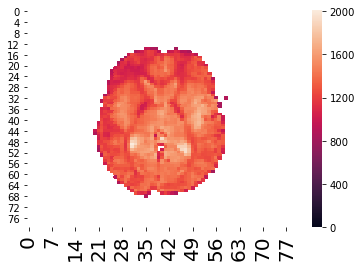

In [303]:
mean_image = np.vstack(data).mean(0).reshape([dims[1], dims[2]])
mean_mask = mean_image < np.percentile(mean_image, 99)/2
sns.heatmap(mean_image, mask=mean_mask)

# cross-validate and get r-score for each voxel

In [304]:
def get_constants(run_lens):
    tot_len = np.sum(run_lens)
    const = np.zeros((tot_len, len(run_lens)))

    for i, rlen in enumerate(run_lens):
        const[i*rlen:(i+1)*rlen, i] = 1
    return const

In [305]:
r2s = []
preds =[]
for run in range(n_runs):
    # fit data using all the other runs
    mask = np.arange(n_runs) != run
    tmpy = np.vstack(compress(data, mask))
    tmpX = np.vstack((compress(design, mask)))
    run_lens = [d.shape[0] for d in compress(data, mask)]
    tmpX = np.c_[tmpX, get_constants(run_lens)]
    
    betas_tmp = np.linalg.lstsq(tmpX, tmpy,  rcond=False)[0][:-(n_runs-1), :]
    
    # left out data
    yhat = design[run].dot(betas_tmp)
    rsq2 = rsquared(data[run], yhat)
    r2s.append(rsq2)
    preds.append(yhat)  

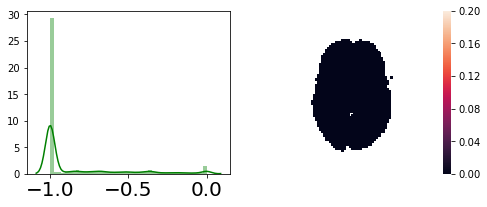

In [306]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

mean_r2 = np.array(r2s).mean(0)
r2_full_data = rsquared(np.vstack(data),np.vstack(preds))
sns.distplot(mean_r2, color='green', ax=ax[0])
#sns.distplot(r2_full_data, color='red', ax=ax[0])

plt_img = mean_r2.copy()
#plt_img[plt_img < 0.2] = 0
sns.heatmap(plt_img.reshape((80,80)), mask=mean_mask, ax=ax[1],
            xticklabels=False, yticklabels=False, vmin=0, vmax=0.2, square=True)
plt.show()

# Select voxels for noise pool

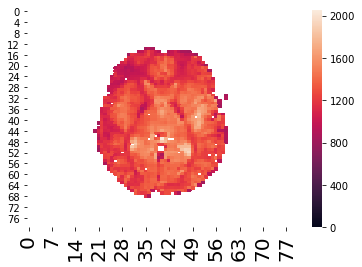

In [218]:
# voxels with r2 below 0 but still "brigth enough
noise_pool = (mean_r2 < 0) & (mean_image.reshape(-1) > np.percentile(mean_image, 99)/2)
sns.heatmap(mean_image, mask=~noise_pool.reshape([dims[1], dims[2]]))

### Calculate variance across betas
\begin{align}
var(\beta) = \sigma^2(X^1X)^{-1}
\end{align}
### Where
\begin{align}
\sigma = \frac{\sum_{i=1}^K(y_i - yhat_i)^2}{N-P}
\end{align}

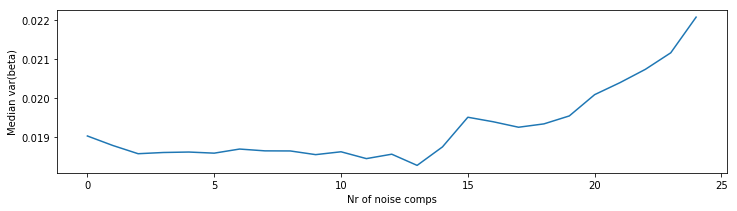

In [44]:
N_np = 49 # size of noise pool
noise_mask = np.zeros(K).astype(bool)
idx = np.argsort(rsq)[:N_np] # sort voxels after r square
noise_mask[idx] = True
noise_pool = y[:, idx]
pcas = PCA().fit_transform(noise_pool)
y_non_np = y[:, np.invert(idx)] # voxels not in the noise pool
    
median_var_betas = np.zeros(N_np)
plt.figure(figsize=(12, 3))
for i, n_pca in enumerate(np.arange(1, idx.size+1)):
    # Add n PCs to design matrix
    Xtmp = np.c_[X, pcas[:, :n_pca]]
    # Fit data
    betas_tmp = np.linalg.lstsq(Xtmp, y_non_np)[0]
    yhat_tmp = Xtmp.dot(betas_tmp)
    # calculate variance
    sigsq_tmp = np.sum((y_non_np - yhat_tmp)**2, axis=0) / (N - Xtmp.shape[1])
    des_var_tmp =  np.diagonal(np.linalg.inv(Xtmp.T.dot(Xtmp)))
    var_betas = sigsq_tmp * des_var_tmp[:, np.newaxis]
    median_var_betas[i] = np.median(var_betas)

plt.plot(median_var_betas[:25])
plt.xlabel('Nr of noise comps')
plt.ylabel('Median var(beta)')
plt.show()